# The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: **“what sorts of people were more likely to survive?”** using passenger data (ie name, age, gender, socio-economic class, etc).

In [959]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

import missingno as msno

SEED = 42

Training set has 891 rows and test set has 418 rows

Training set has 12 features, test set has 11 features

One extra feature in training set is `Survived` feature, which is the target variable.

In [960]:
def concat_df(train_data, test_data):
    '''
    Returns a concatenated df of train and test data
    
    Concatenate to ensure uniform transformations, data consistency and indices are independent
    '''
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def split_df(all_data):
    '''
    Splits aggregate into train and test sets, following any transformations
    
    Returns train, test data in that format
    '''
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set'

dfs = [df_train, df_test]

print("Number of Training Examples = {}".format(df_train.shape[0]))
print("Number of Training Features = {}".format(df_train.shape[1]))
print("Number of Test Examples = {}".format(df_test.shape[0]))
print("Number of Test Features = {}".format(df_test.shape[1]))
print("Training X Shape = {}".format(df_train.shape))
print("Test X Shape = {}".format(df_test.shape))
print("Training y Shape = {}".format(df_train.Survived.shape[0]))
print("Test y Shape = {}".format(df_test.shape[0]))

print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Training Features = 12
Number of Test Examples = 418
Number of Test Features = 11
Training X Shape = (891, 12)
Test X Shape = (418, 11)
Training y Shape = 891
Test y Shape = 418
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [961]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# 1. Exploratory Data Analysis

### 1.1 Overview

- `PassengerId` is the unique id of the row and it doesn't have any effect on the target
- `Survived` is the target variable we are trying to predict (0 or 1):
    - 1 = Survived
    - 0 = Not Survived
- `Pclass` (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature with three unique values (1, 2 or 3):
    - 1 = Upper Class
    - 2 = Middle Class
    - 3 = Lower Class
- `Sex` is a categorical nominal feature with two unique values (male or female)
- `Age` is a categorical ordinal feature with values ranging from [0, 80] years
- `SibSp` is the total number of passengers' siblings and spouse
- `Parch` is the total number of passengers' parents and children
- `Ticket` is the unique ticket number of passenger 
- `Fare` is the passenger fee
- `Cabin` is the cabin of passenger
- `Embarked` is the port of embarkation and it is a categorical nominal feature with three unique values (C, Q or S):
    - C = Cherbourg
    - Q = Queenstown
    - S = Southampton

In [962]:
print(df_train.info())
df_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0000,NaN,S
524,525,0,3,"Kassem, Mr. Fared",male,NaN,0,0,2700,7.2292,NaN,C
456,457,0,1,"Millet, Mr. Francis Davis",male,65.0,0,0,13509,26.5500,E38,S


In [963]:
df_test.info()
df_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
42,934,3,"Goldsmith, Mr. Nathan",male,41.0,0,0,SOTON/O.Q. 3101263,7.8500,NaN,S
240,1132,1,"Lindstrom, Mrs. Carl Johan (Sigrid Posse)",female,55.0,0,0,112377,27.7208,NaN,C
301,1193,2,"Malachard, Mr. Noel",male,NaN,0,0,237735,15.0458,D,C


### 1.2 Missing Values

As seen below, some columns have missing values. `display_missing` function returns the count of missing values for every column in both training and test sets.
- Training Set has missing values in `Age`, `Cabin` and `Embarked` columns
- Test Set has missing values in `Age`, `Fare` and `Cabin` columns 

It is convenient to use concatenated training and test set while dealing with missing values, otherwise filled data in either set may overfit to training or testing set samples. The count of missing values in `Age`, `Embarked` and `Fare` are smaller compared to the total sample, but roughly 80% of the `Cabin` is missing for both sets. Missing values for `Age`, `Embarked` and `Fare` can be filled with descriptive statistical measures, but that won't work for `Cabin`.

In [964]:
def display_missing(df: pd.DataFrame | None):
    missing_vals = df.isna().sum()
    proportion_missing_vals = missing_vals / len(df)
    missing_table_df = pd.concat([missing_vals, proportion_missing_vals], axis=1)
    missing_table_df.columns = ['Missing Values', 'Proportion Missing Values']
    
    return missing_table_df

for df in dfs:
    print(df.name)
    print(display_missing(df))
    print('\n')

Training Set
             Missing Values  Proportion Missing Values
PassengerId               0                   0.000000
Survived                  0                   0.000000
Pclass                    0                   0.000000
Name                      0                   0.000000
Sex                       0                   0.000000
Age                     177                   0.198653
SibSp                     0                   0.000000
Parch                     0                   0.000000
Ticket                    0                   0.000000
Fare                      0                   0.000000
Cabin                   687                   0.771044
Embarked                  2                   0.002245


Test Set
             Missing Values  Proportion Missing Values
PassengerId               0                   0.000000
Pclass                    0                   0.000000
Name                      0                   0.000000
Sex                       0              

<Axes: >

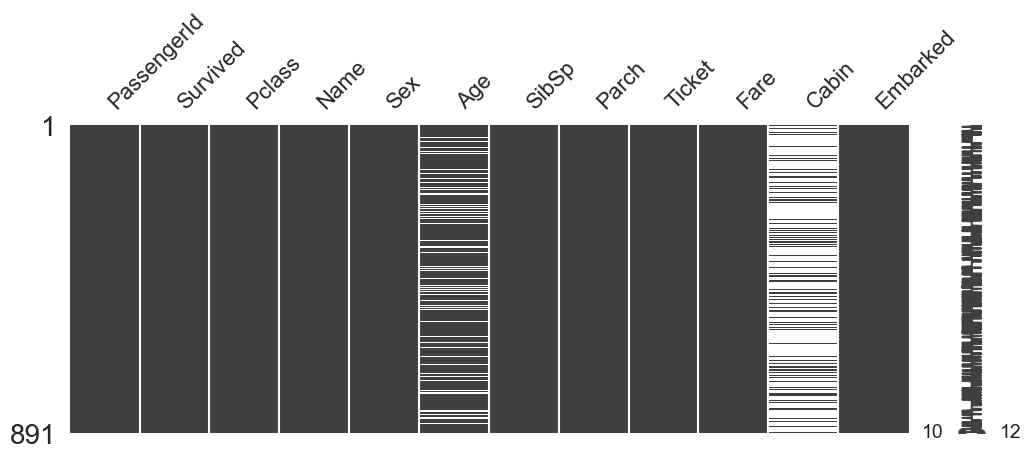

In [965]:
msno.matrix(df_train, figsize=(12,4))

<Axes: >

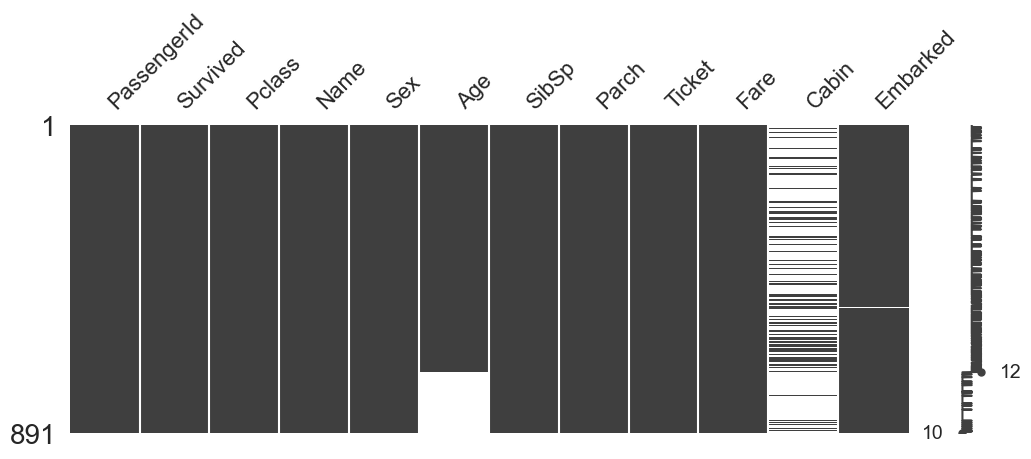

In [966]:
sorted = df_train.sort_values('Age')
msno.matrix(sorted, figsize=(12,4))

### 1.2.1 Age

The type of missingness is Missing at Random (MAR).

`Age` is right skewed, using Median Age for impute is appropriate.

Imputing `Age` based on overall median age of entire dataset may not be optimal, as this approach overlooks the distinct relationships that `Age` shares with other key variables in the dataset. 

A more tailored approach would be to impute `Age` based on `Pclass` groups due to the high correlation of `Pclass` with `Age` (0.408106) and `Survived` (0.338481). It is also more logical to group ages by passenger classes instead of other features.

In [967]:
df_all_corr = df_all.corr(method='pearson').abs().unstack().sort_values(ascending=False).reset_index()
df_all_corr.columns = ["Feature 1", "Feature 2", "Correlation Coefficient"]
df_all_corr[df_all_corr['Feature 1'] == 'Pclass'] 

,Feature 1,Feature 2,Correlation Coefficient
3,Pclass,Pclass,1.000000
8,Pclass,Fare,0.558629
10,Pclass,Age,0.408106
14,Pclass,Survived,0.338481
31,Pclass,SibSp,0.060832
35,Pclass,PassengerId,0.038354
44,Pclass,Parch,0.018322


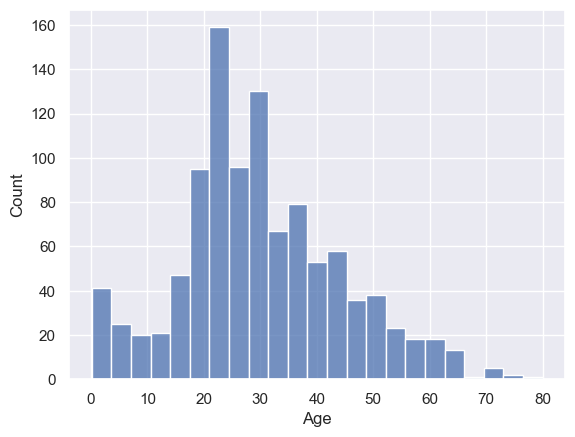

In [968]:
sns.histplot(x=df_all['Age'])
plt.show()

In [969]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']
for pclass in [1,2,3]:
    for sex in ['male', 'female']:
        print("Median age for {} of Pclass {}: {}".format(sex, pclass, age_by_pclass_sex[sex][pclass]))
print("Median age of all individuals: {}".format(df_all['Age'].median()))

# Filling in missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age for male of Pclass 1: 42.0
Median age for female of Pclass 1: 36.0
Median age for male of Pclass 2: 29.5
Median age for female of Pclass 2: 28.0
Median age for male of Pclass 3: 25.0
Median age for female of Pclass 3: 22.0
Median age of all individuals: 28.0


In [970]:
df_all.isna().sum()

Age               0
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

### 1.2.2 Embarked

`Embarked` is a categorical feature (so using Mode for Impute) and there are only 2 missing values in the entire dataset. Both records show that both individuals are female, upper class, share the same cabin and have the same ticket number. 

This means that they both know each other and embarked from the same port together. 

The mode of `Embarked` for an upper class female passenger is **C (Cherbourg)**, but that doesn't necessarily mean that they embarked from that port.

In [971]:
df_all[df_all.isna()['Embarked']]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


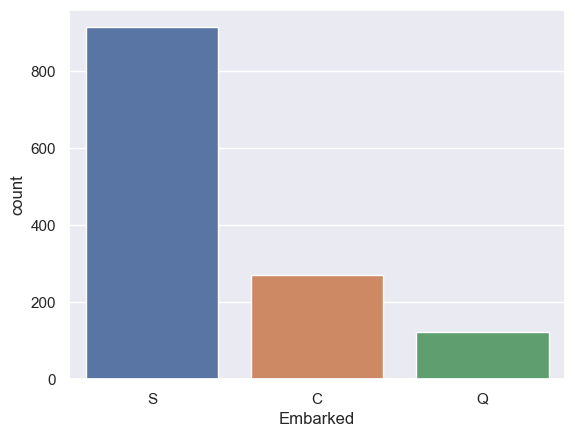

In [972]:
sns.countplot(x=df_all['Embarked'])
plt.show()

In [973]:
df_all[(df_all['Pclass'] == 1) & (df_all['Sex'] == 'female')]['Embarked'].mode()

0    C
Name: Embarked, dtype: object

When googling **Stone, Mrs. George Nelson (Martha Evelyn)**, I found that she embarked from **S (Southampton)** with her maid **Amelie Icard**, in this page <a href="https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html">Martha Evelyn Stone: Titanic Survivor</a>

> Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28.

Missing values in `Embarked` will be filled with **S (Southampton)**

In [974]:
df_all['Embarked'] = df_all['Embarked'].fillna('S')

In [975]:
df_all.isna().sum()

Age               0
Cabin          1014
Embarked          0
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

### 1.2.3 Fare

There is only one passenger with a missing `Fare` value. `Fare` is right skewed, so Median Fare price for impute is appropriate.

We can assume `Fare` is related to family size (`Parch` and `SibSp`) and `Pclass` features. 

Median `Fare` price of a male with a third class ticket with no family is a logical choice to fill the missing value.

In [976]:
df_all[df_all['Fare'].isna()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


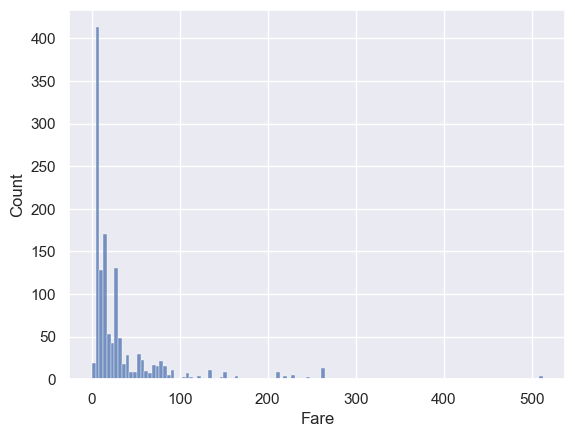

In [977]:
sns.histplot(x=df_all['Fare'])
plt.show()

In [978]:
median_fare_val = df_all[(df_all['Parch'] == 0) & (df_all['SibSp'] == 0) & (df_all['Sex'] == 'male') & (df_all['Pclass'] == 3)]['Fare'].median()
df_all['Fare'] = df_all['Fare'].fillna(median_fare_val)
df_all

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,25.0,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262
1307,25.0,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309


### 1.2.4 Cabin

The feature `Cabin` has about 80% of its data missing. Each `Cabin` will have a different survival rate, so therefore we can't completely ignore the feature and must fill in the missing data.

The first letter of each `Cabin` refers to the decks in which the cabins were located at. 

<img src="https://vignette.wikia.nocookie.net/titanic/images/f/f9/Titanic_side_plan.png/revision/latest?cb=20180322183733" width="1200" height="400" />

- On the boat deck, there were **6** rooms labeled as **T, U, W, X, Y, Z** but only **T** cabin is present in dataset.
- A, B, C decks were only for 1st class passengers
- D, E decks were for all classes
- F, G decks were for both 2nd and 3rd class passengers

In [979]:
for Pclass in [1,2,3]:
    class_types = set(df_all[df_all.Pclass == Pclass].sort_values(by='Cabin').dropna().Cabin.apply(lambda x: x[0]))
    
    print("Pclass {} occupies {} decks".format(Pclass, class_types))

Pclass 1 occupies {'C', 'A', 'D', 'E', 'T', 'B'} decks
Pclass 2 occupies {'D', 'E', 'F'} decks
Pclass 3 occupies {'F', 'E', 'G'} decks


In [980]:
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={"Name": "Count"}).T
df_all_decks

Deck     A   B   C   D      E         F     G   M            T
Pclass   1   1   1   1  2   1  2  3   2  3  3   1    2    3  1
Count   22  65  94  40  6  34  4  3  13  8  5  67  254  693  1

            0          1           2
A  100.000000   0.000000    0.000000
B  100.000000   0.000000    0.000000
C  100.000000   0.000000    0.000000
D   86.956522  13.043478    0.000000
E   82.926829   9.756098    7.317073
F    0.000000  61.904762   38.095238
G    0.000000   0.000000  100.000000
M    6.607495  25.049310   68.343195
T  100.000000   0.000000    0.000000


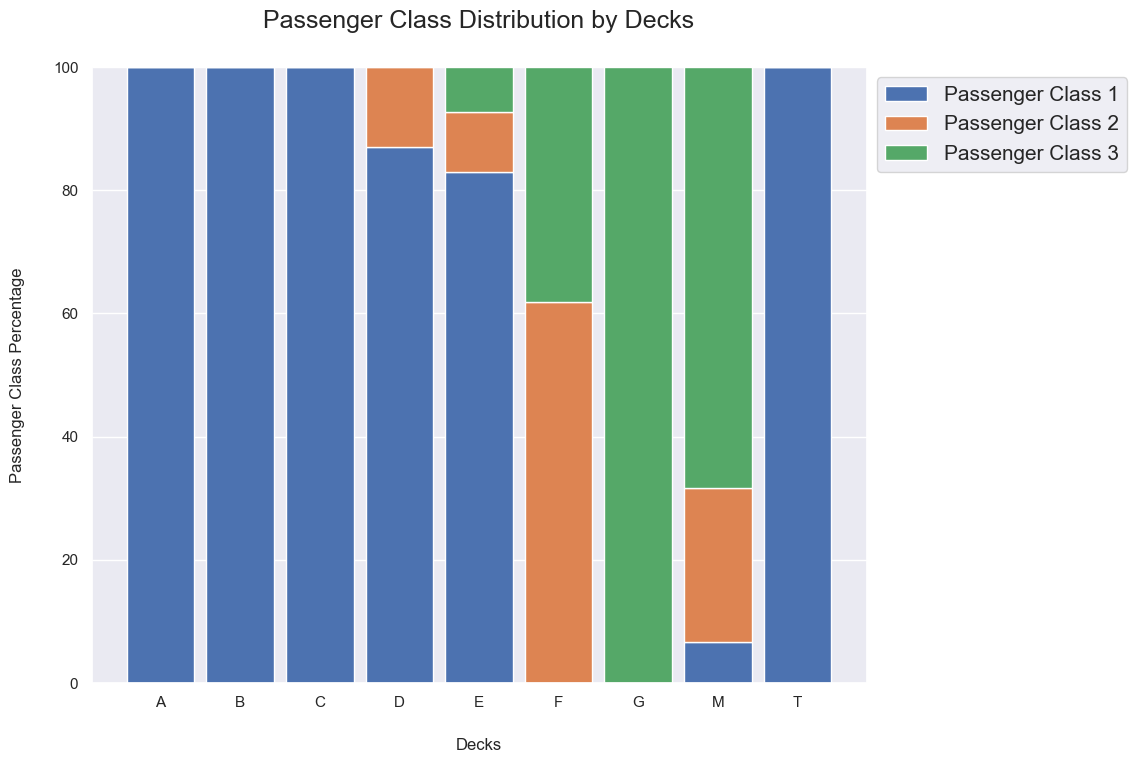

In [981]:
## Determining Passenger Class Distribution by Decks 
def get_pass_class_distribution(df):
    '''
    Determines Passenger Class Distribution by Decks
    
    Returns:
    - decks_count: Count Distribution of Passengers by Decks
    - decks_percentage: Percentage Distribution of Passengers by Decks
    '''
    
    decks_count = defaultdict(dict)
    decks = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T']

    for deck in decks:
        for pclass in [1,2,3]:
            try:
                count = df[deck][pclass][0]
                decks_count[deck][pclass] = count
            except KeyError:
                decks_count[deck][pclass] = 0

    df_decks = pd.DataFrame(decks_count)
    decks_percentage = {}

    for col in df_decks.columns:
        decks_percentage[col] = [(count / sum(df_decks[col])) * 100 for count in df_decks[col]]
        
    return decks_count, decks_percentage

def display_pclass_dist(df_percent):
    decks = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T']
    bar_count = np.arange(len(decks))
    bar_width = 0.85
    
    df_percent = pd.DataFrame(df_percent).T
    
    p1, p2, p3 = df_percent[0], df_percent[1], df_percent[2]
    
    print(df_percent)
    
    plt.figure(figsize=(10,8))
    plt.bar(bar_count, p1, width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, p2, bottom=p1, width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, p3, bottom=p1 + p2, width=bar_width, label='Passenger Class 3')
    plt.xticks(bar_count, decks)
    plt.xlabel('Decks', labelpad=20)
    plt.ylabel('Passenger Class Percentage', labelpad=20)
    plt.title('Passenger Class Distribution by Decks', y=1.05, size=18)
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), prop={'size': 15})
    plt.show()

x, y = get_pass_class_distribution(df_all_decks)
display_pclass_dist(y)

- 100% of A, B, and C decks are 1st class passengers
- Deck D has 87% 1st class, and 13% 2nd class passengers
- Deck E has 83% 1st class, 10% 2nd class and 7% 3rd class passengers
- Deck F has 62% 2nd class and 38% 3rd class passengers
- 100% of Deck G are 3rd class passengers
- There is only 1 person in T cabin whom is a 1st class passenger, so 100% of Deck T are 1st class passengers. The `T` cabin passenger has the closest resemblance to `A` deck passengers so they will be grouped with `A` deck.
- Passengers labelled as M are the missing values in the `Cabin` feature. I don't think it is possible to find those passengers' real `Deck` so `M` will be used.

In [982]:
cabin_T_idx = df_all.Cabin[df_all.Cabin == 'T'].index
df_all.loc[cabin_T_idx, 'Deck'] = 'A'

In [983]:
df_all[df_all.Cabin == 'T']

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck
339,45.0,T,S,35.5,"Blackwell, Mr. Stephen Weart",0,340,1,male,0,0.0,113784,A


In [984]:
df_all_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Age', 'Cabin', 'Embarked', 'Fare', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket']).rename(columns={"Name": "Count"}).T
df_all_survived

Deck       A       B       C       D       E       F       G        M     
Survived 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0  0.0  1.0
Count      9   7  12  35  24  35   8  25   8  24   5   8   2   2  481  206

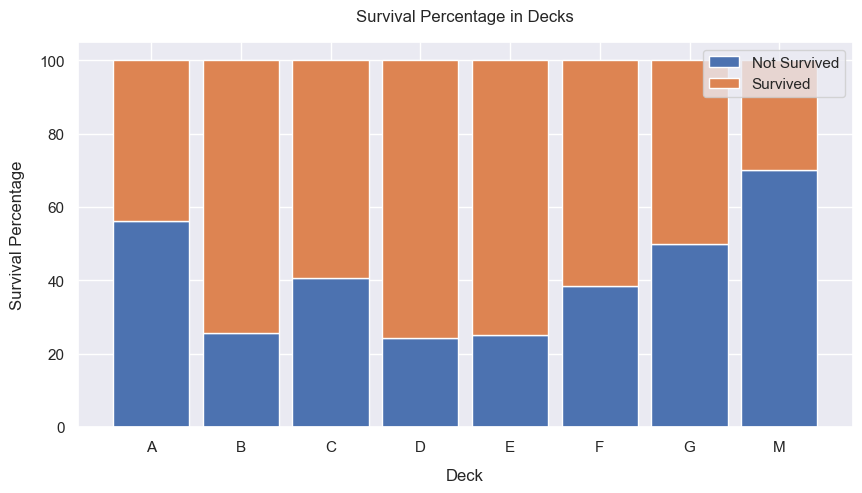

,0,1
M,70.014556,29.985444
A,56.250000,43.750000
G,50.000000,50.000000
C,40.677966,59.322034
F,38.461538,61.538462
B,25.531915,74.468085
E,25.000000,75.000000
D,24.242424,75.757576


In [985]:
def get_survived_distribution_decks(df):
    # survived distribution 
    survived_dict = defaultdict(dict)
    decks = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'M']

    for deck in decks:
        for survived in [0, 1]:
            count = df[deck][survived][0]
            survived_dict[deck][survived] = count
            
    # percent survived distribution
    df_survived = pd.DataFrame(survived_dict)
    survived_percent = {}
    
    for col in df_survived.columns:
        survived_percent[col] = [(count / df_survived[col].sum()) * 100 for count in df_survived[col]]

    return survived_dict, survived_percent

def display_survived_distribution_decks(percentages):
    df_percentages = pd.DataFrame(percentages).T
    decks = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'M']
    bar_count = np.arange(len(decks))
    bar_width = 0.85
    
    s0, s1 = df_percentages[0], df_percentages[1]
    plt.figure(figsize=(10, 5))
    plt.bar(bar_count, s0, width=bar_width, label='Not Survived')
    plt.bar(bar_count, s1, bottom=s0, width=bar_width, label='Survived')
    plt.xticks(bar_count, decks)
    plt.title('Survival Percentage in Decks',pad=15)
    plt.ylabel('Survival Percentage', labelpad=10)
    plt.xlabel('Deck', labelpad=10)
    plt.legend(loc='upper right')
    plt.show() 
    
    return df_percentages
    
survived_dict, survived_percent = get_survived_distribution_decks(df_all_survived)
x = display_survived_distribution_decks(survived_percent)
x.sort_values(by=1)

Every `Deck` has different survival rates, with `Deck` B, D, E and F with the highest survival rates. Decks B, D, and E are mostly occupied by 1st class passengers. 

M has the lowest survival rate which is mostly occupied by 2nd and 3rd class passengers. Cabins used by 1st class passengers have higher survival rates than cabins used by 2nd and 3rd class passengers.

In my opinion, M has the lowest survival rate because they couldn't retrieve the cabin data of the victims. Labelling that group as M is a reasonable way to handle missing data. **It is a unique group with shared characteristics**.

- A, B and C decks are labeled as ABC because all of them have only 1st class passengers.
- D and E decks are labelled as DE because both of them have similar passenger class distribution and same survival rate.
- F and G decks are labelled as FG because of the similar passenger distribution and similar survival rates.
- M deck doesn't need to be grouped with other decks because it is very different from others and has the lowest survival rate

In [986]:
df_all.Deck.value_counts()

M    1014
C      94
B      65
D      46
E      41
A      23
F      21
G       5
Name: Deck, dtype: int64

In [987]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all.Deck.value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

`Cabin` feature will be dropped as `Deck` feature will be used instead.

Following on, after splitting into separate train / test sets, there are no more missing values present in both sets. 

In [988]:
df_all.drop(['Cabin'], inplace=True, axis=1)

df_train, df_test = split_df(df_all)
dfs = [df_train, df_test]

df_train.name = 'Training Set'
df_test.name = 'Test Set'

for df in dfs:
    print(df.name)
    print(display_missing(df))
    print('\n')

Training Set
             Missing Values  Proportion Missing Values
Age                       0                        0.0
Embarked                  0                        0.0
Fare                      0                        0.0
Name                      0                        0.0
Parch                     0                        0.0
PassengerId               0                        0.0
Pclass                    0                        0.0
Sex                       0                        0.0
SibSp                     0                        0.0
Survived                  0                        0.0
Ticket                    0                        0.0
Deck                      0                        0.0


Test Set
             Missing Values  Proportion Missing Values
Age                       0                        0.0
Embarked                  0                        0.0
Fare                      0                        0.0
Name                      0              

In [989]:
df_train.Survived.value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

### 1.3 Target Distribution

The target variable of interest is `Survived`. 

In the training set, 38.4% are categorised as Class 1, and 61.62% as Class 0.

In [990]:
df_train.Survived.value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

342 of 891 passengers survived, which is 38.38% of the training set.
549 of 891 passengers didn't survived, which is 61.62% of the training set.


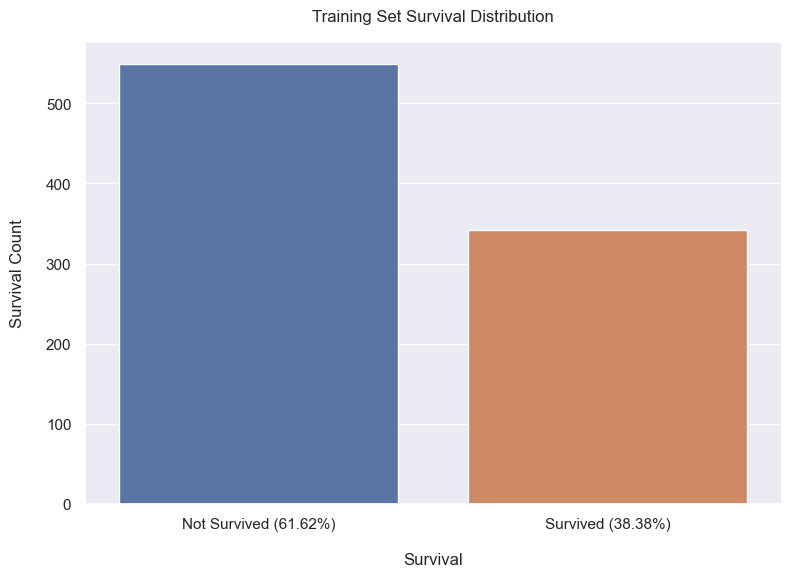

In [991]:
not_survived, survived = df_train.Survived.value_counts()
not_survived_per, survived_per = (not_survived / len(df_train)) * 100, (survived / len(df_train)) * 100
 
print("{} of {} passengers survived, which is {:.2f}% of the training set.".format(survived, len(df_train), survived_per))
print("{} of {} passengers didn't survived, which is {:.2f}% of the training set.".format(not_survived, len(df_train), not_survived_per))

plt.figure(figsize=(9,6))
sns.countplot(x=df_train.Survived)

plt.xlabel("Survival", labelpad=15)
plt.ylabel("Survival Count", labelpad=15)

plt.xticks((0,1), ['Not Survived ({:.2f}%)'.format(not_survived_per), 'Survived ({:.2f}%)'.format(survived_per)])

plt.title("Training Set Survival Distribution", pad=15)
plt.show()

### 1.4 Correlations

`Fare` and `Pclass` features are highly correlated in their respective sets, with 0.549500 in Training and 0.577488 in the Test Set. 

They are the highest correlated. There are 10 correlations in training set and 6 correlations in the test set that are higher than 0.1

In [992]:
df_train_corr = df_train.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(ascending=False).reset_index()
df_train_corr.columns = ['Feature 1', 'Feature 2', 'Correlation Coefficient']
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index, inplace=True)
df_train_corr

,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.549500
8,Age,Pclass,0.417667
10,Parch,SibSp,0.414838
12,Pclass,Survived,0.338481
14,Fare,Survived,0.257307
16,Age,SibSp,0.249747
18,Parch,Fare,0.216225
20,Parch,Age,0.176733
22,SibSp,Fare,0.159651
24,Age,Fare,0.124061


In [993]:
df_test_corr = df_test.drop(columns=['PassengerId']).corr().abs().unstack().sort_values(ascending=False).reset_index()
df_test_corr.columns = ['Feature 1', 'Feature 2', 'Correlation Coefficient']

df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1].index, inplace=True)

df_test_corr

,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.577488
8,Pclass,Age,0.526789
10,Fare,Age,0.345351
12,Parch,SibSp,0.306895
14,Fare,Parch,0.230410
16,SibSp,Fare,0.172031
18,Age,SibSp,0.082493
20,Age,Parch,0.059993
22,Pclass,Parch,0.018721
24,SibSp,Pclass,0.001087


In [994]:
print('High Correlations for Training Set')
df_train_corr[df_train_corr['Correlation Coefficient'] > 0.1]

High Correlations for Training Set


,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.549500
8,Age,Pclass,0.417667
10,Parch,SibSp,0.414838
12,Pclass,Survived,0.338481
14,Fare,Survived,0.257307
16,Age,SibSp,0.249747
18,Parch,Fare,0.216225
20,Parch,Age,0.176733
22,SibSp,Fare,0.159651
24,Age,Fare,0.124061


In [995]:
print('High Correlations for Test Set')
df_test_corr[df_test_corr['Correlation Coefficient'] > 0.1]

High Correlations for Test Set


,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.577488
8,Pclass,Age,0.526789
10,Fare,Age,0.345351
12,Parch,SibSp,0.306895
14,Fare,Parch,0.230410
16,SibSp,Fare,0.172031


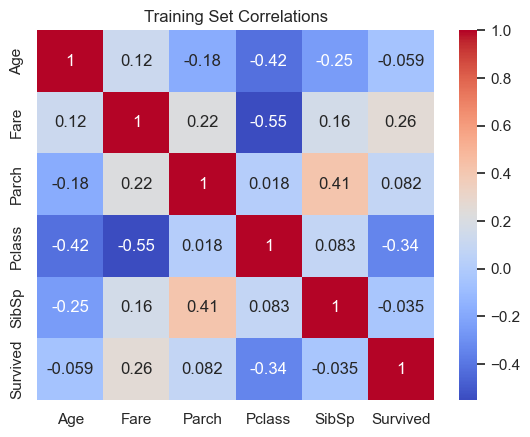

In [996]:
sns.heatmap(df_train.drop(columns=['PassengerId']).corr(), annot=True, cmap='coolwarm')
plt.title('Training Set Correlations')
plt.show()

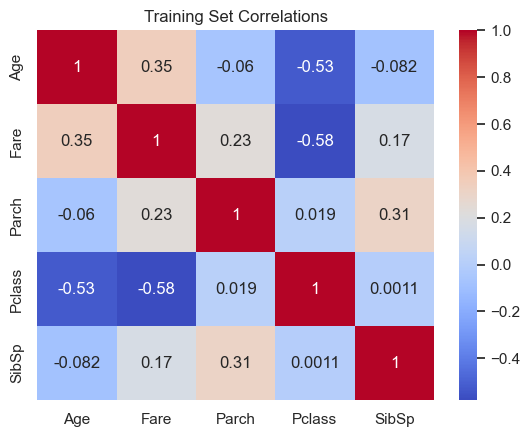

In [997]:
sns.heatmap(df_test.drop(columns=['PassengerId']).corr(), annot=True, cmap='coolwarm')
plt.title('Training Set Correlations')
plt.show()

### 1.5 Target Distribution in Features

In [998]:
df_train

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,M
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,ABC
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,M
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,ABC
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,M
...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,S,13.0000,"Montvila, Rev. Juozas",0,887,2,male,0,0.0,211536,M
887,19.0,S,30.0000,"Graham, Miss. Margaret Edith",0,888,1,female,0,1.0,112053,ABC
888,22.0,S,23.4500,"Johnston, Miss. Catherine Helen ""Carrie""",2,889,3,female,1,0.0,W./C. 6607,M
889,26.0,C,30.0000,"Behr, Mr. Karl Howell",0,890,1,male,0,1.0,111369,ABC


#### 1.5.1 Continuous Features

Both of the continuous features (`Age` and `Fare`) have good split points and spikes for a decision tree to learn. One potential problem for both feature is the distribution has more bumps and spikes in training set, but it is smoother in test set. 

Model may not be able to generalize to test set because of this reason.

- Distribution of `Age` features shows that passengers younger than 16 have a higher survival rate than any of the other age groups.
- Distribution of `Fare` features shows that survival rate is higher on distribution tails. The distribution has a positive right skew because of the extremely large outliers.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


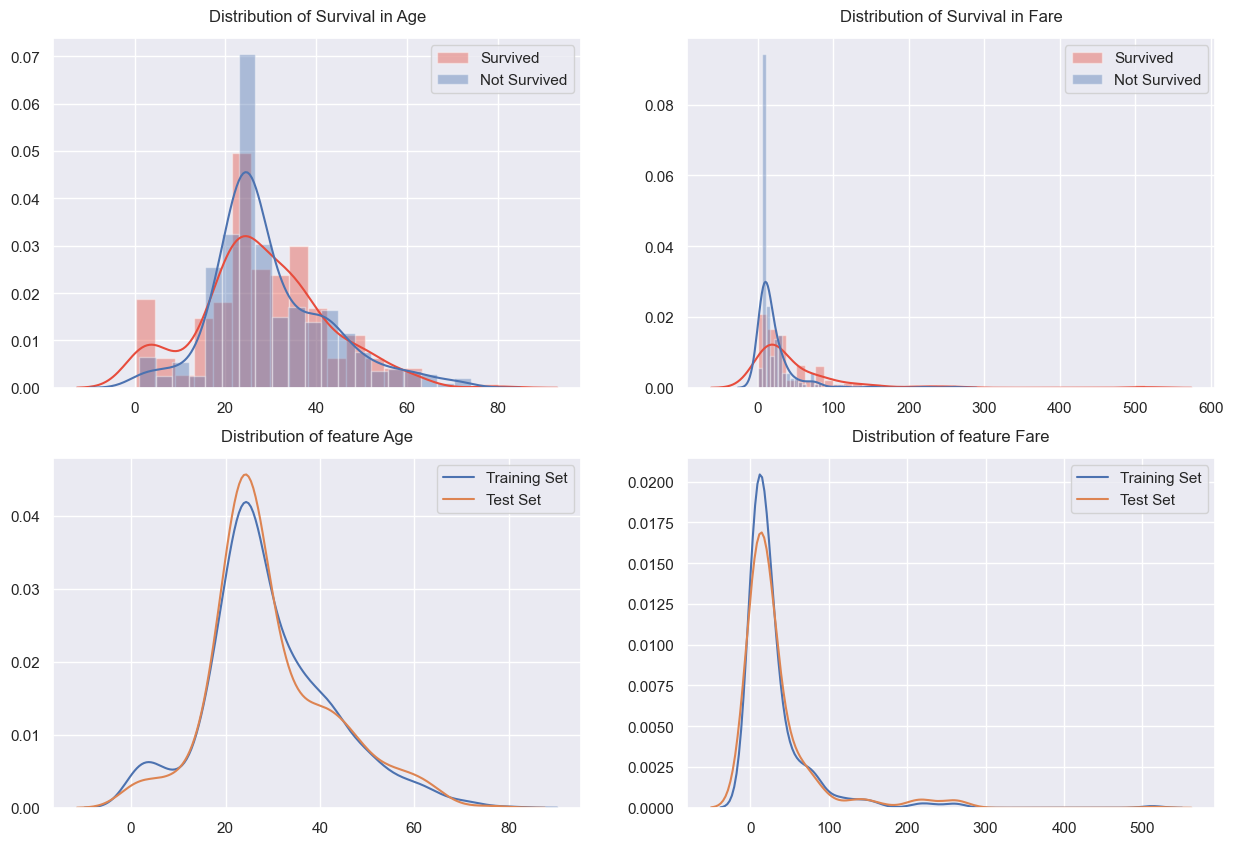

In [999]:
survived = df_train['Survived'] == 1
con_features = ['Age', 'Fare']

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,10))

for i, feature in enumerate(con_features):
    sns.distplot(df_train[survived][feature], hist=True, color='#e74c3c', label='Survived', ax=axs[0][i])
    sns.distplot(df_train[~survived][feature], hist=True, label='Not Survived', ax=axs[0][i])
    axs[0][i].set_title("Distribution of Survival in {}".format(feature), pad=12)
    axs[0][i].set_xlabel("")
    axs[0][i].set_ylabel("")
    axs[0][i].legend()
    
    sns.distplot(df_train[feature], label="Training Set", hist=False, ax=axs[1][i])
    sns.distplot(df_test[feature], label='Test Set', hist=False, ax=axs[1][i])
    
    axs[1][i].set_title("Distribution of feature {}".format(feature), pad=12)
    axs[1][i].legend()
    axs[1][i].set_xlabel("")
    axs[1][i].set_ylabel("")
    
    plt.legend()
plt.show()

### 1.5.2 Categorical Features

The categorical features (`Embarked`, `Parch`, `Pclass`, `SibSp` and `Deck`)

In [1000]:
df_train[df_train.Survived == 1]['Embarked']

1      C
2      S
3      S
8      S
9      C
      ..
875    C
879    C
880    S
887    S
889    C
Name: Embarked, Length: 342, dtype: object

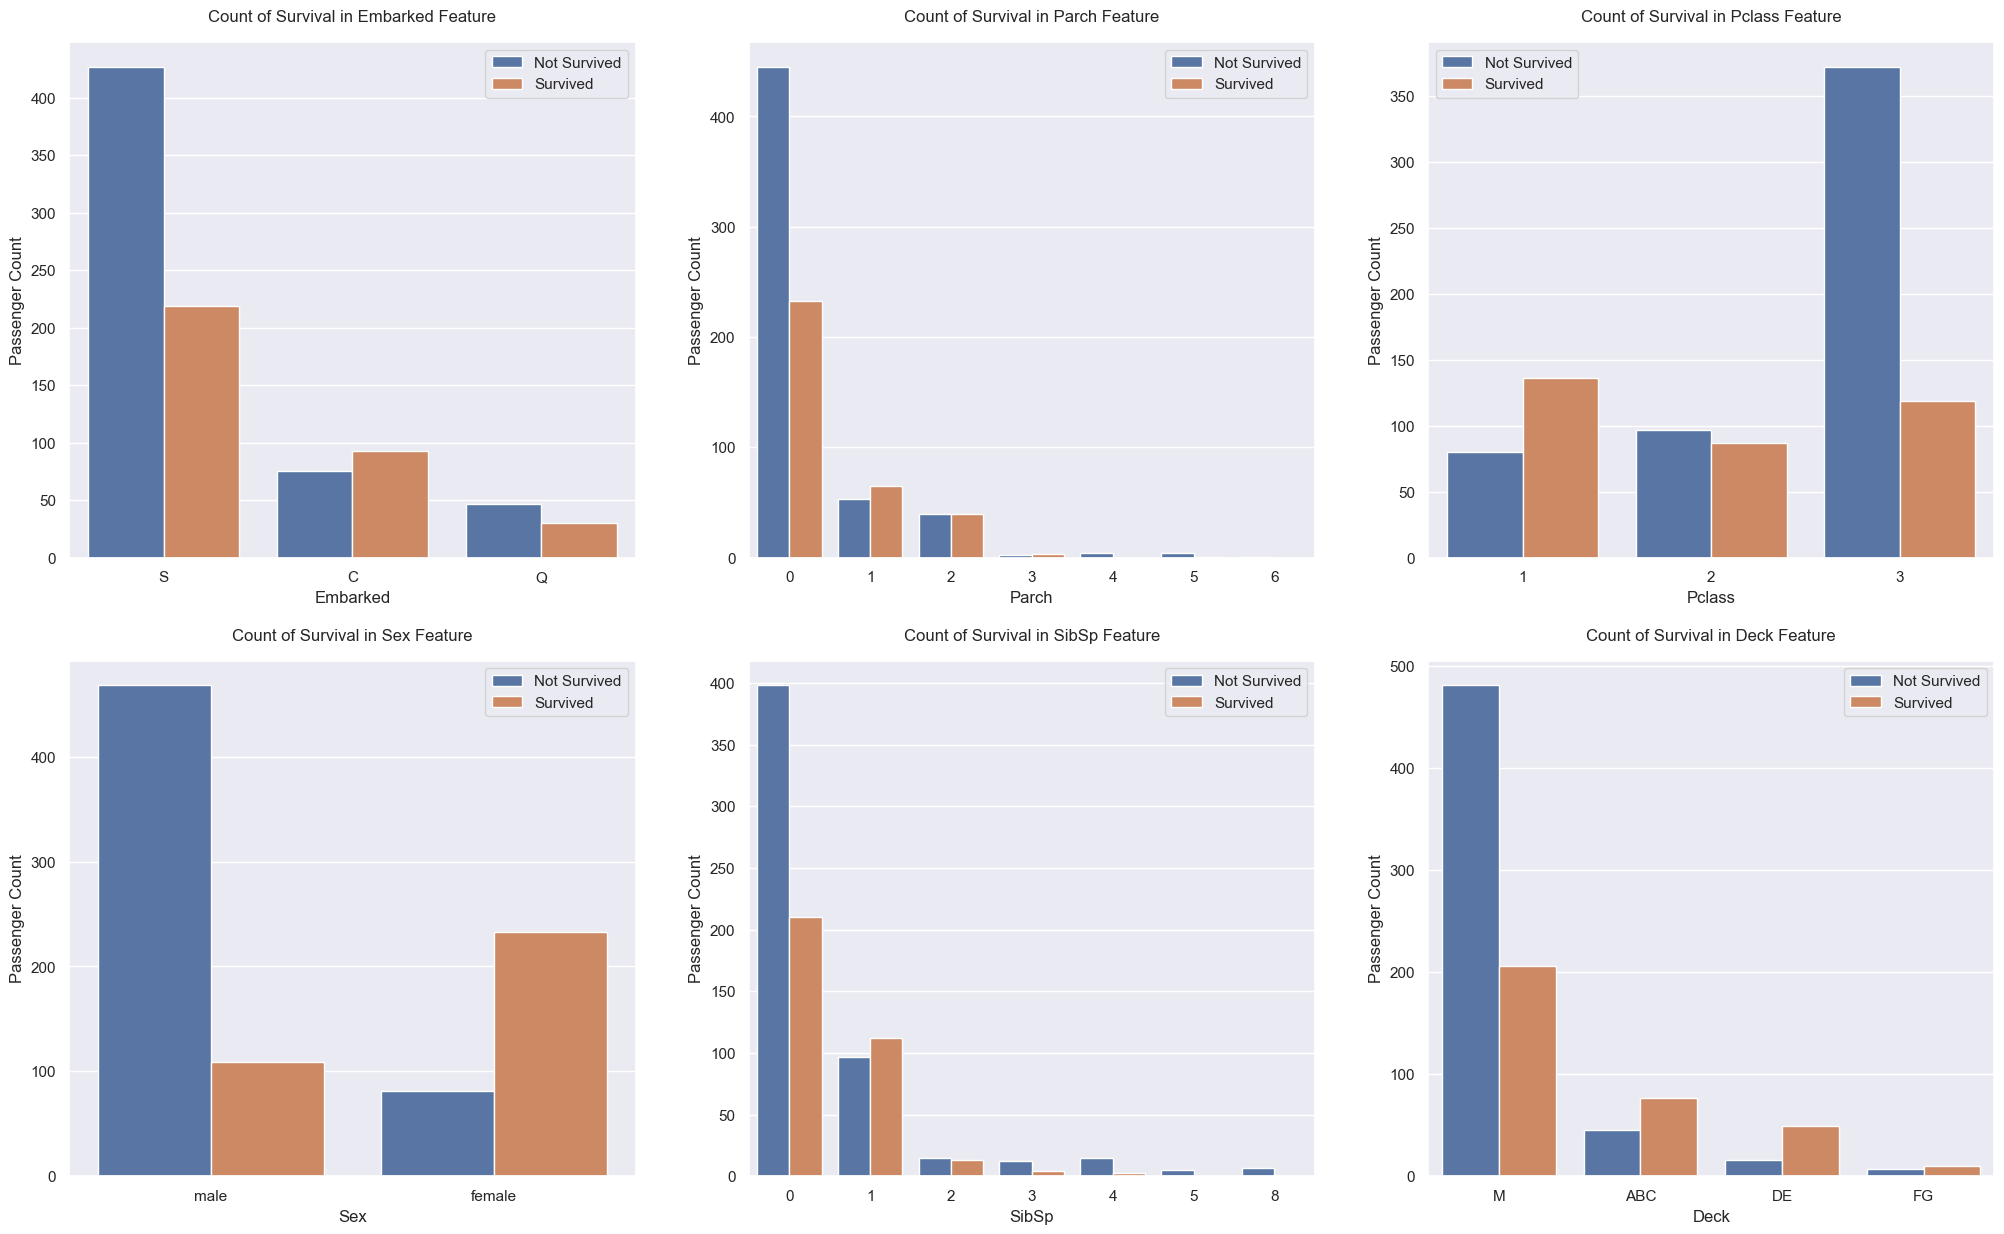

In [1001]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,6))
fig.subplots_adjust(right=1.5, top=2)
features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

for i,feature in enumerate(features):
    sns.countplot(data=df_train, x=feature, hue='Survived', ax=ax[0 if i < 3 else 1][i % 3])
    ax[0 if i < 3 else 1][i % 3].set_title("Count of Survival in {} Feature".format(feature), pad=15)
    ax[0 if i < 3 else 1][i % 3].set_xlabel(feature)
    ax[0 if i < 3 else 1][i % 3].set_ylabel('Passenger Count')
    ax[0 if i < 3 else 1][i % 3].legend(['Not Survived', 'Survived'])

plt.show()

## 1.6 Conclusion

Most of the features are correlated with each other. This relationship can be used to create new features with feature transformation and feature interaction. 
- Feature Transformation involves altering the distribution or scale of singular features to improve the relationship with the target variable.
- Feature Interaction involves combining features to capture combined effect on the target variable.

Split points and spikes are visible in continuous features. They can be captured easily with a decision tree model, but linear models may not be able to spot them.

Categorical features have very different distinct distributions with different survival rates. These features can be one-hot encoded. Some of those features may be combined with each other to make new features.

Created a new feature called `Deck` and dropped the `Cabin` feature during **Exploratory Data Analysis**.

In [1002]:
df_all = concat_df(df_train, df_test)
df_all.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,M,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,ABC,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,M,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,ABC,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,M,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


# 2. Feature Engineering

## 2.1 Binning Continuous Features

### 2.1.1 Fare

`Fare` feature is positively right skewed and survival rate is extremely high on the right end. 13 quantile based bins are used for `Fare` feature. 

The groups on the left side of the graph has the lowest survival rate and the groups at the right side of the graph has the highest survival rate. 

The high survival rate was not visible in the distribution graph. There is also an unusual group **(15.742, 23.25)** in the middle with high survival rate.

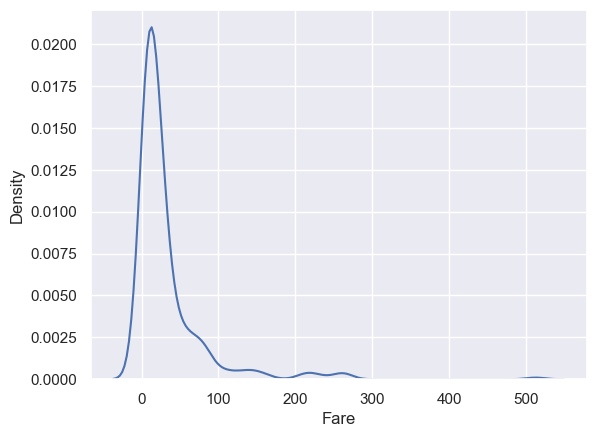

In [1003]:
sns.distplot(df_all.Fare, hist=False)
plt.show()

In [1004]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

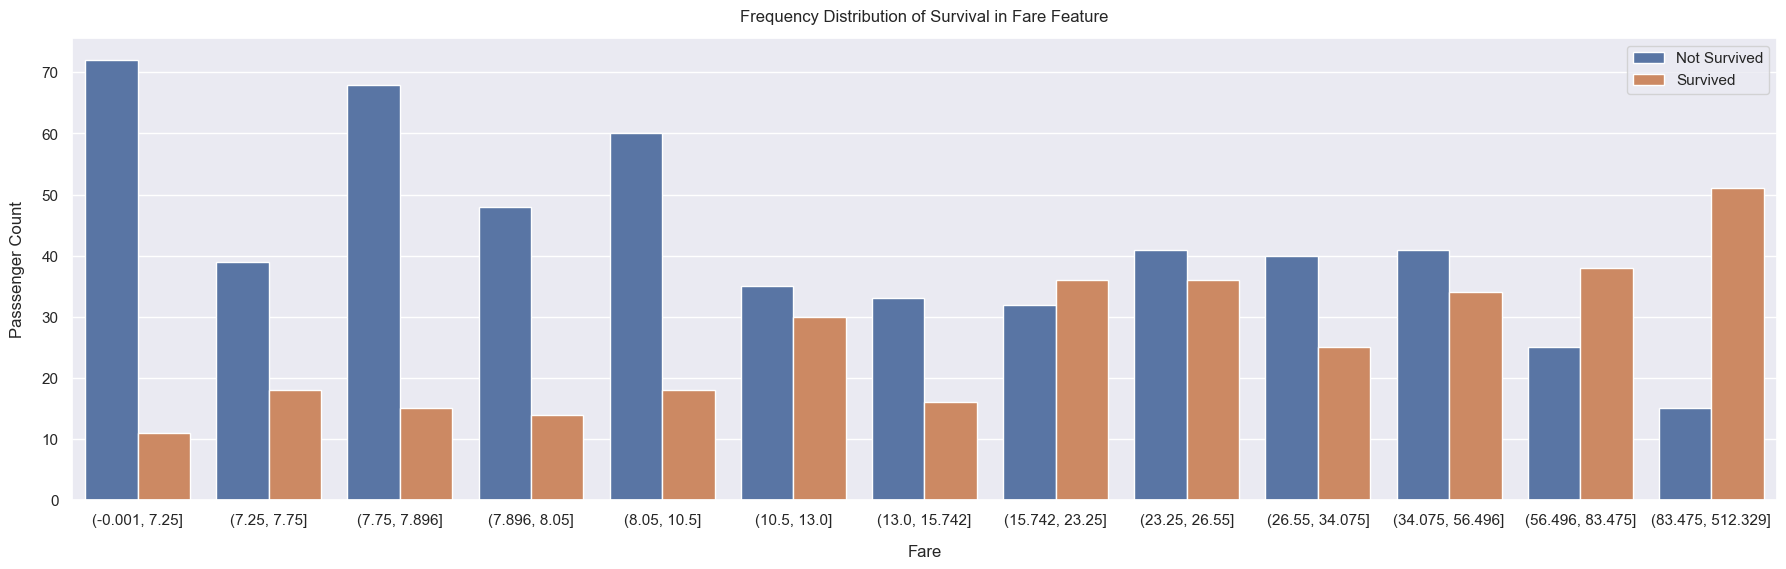

In [1005]:
plt.figure(figsize=(22,6))
sns.countplot(data=df_all, x='Fare', hue='Survived')
plt.title('Frequency Distribution of Survival in Fare Feature', pad=12)
plt.ylabel("Passsenger Count", labelpad=12)
plt.xlabel("Fare", labelpad=12)
plt.legend(['Not Survived', 'Survived'])
plt.show()

### 2.1.2 Age

The first bin has the highest survival rate, and the 4th bin has the lowest survival rate. 

The `Age` feature follows a normal distribution, as described by the Q-Q Plot and running Shapiro-Wilk Test.

There is also an unusual group **(34.0, 40.0]** with high survival rate.

In [1051]:
from scipy.stats import shapiro

epsilon = 0.05
shapiro(df_all.Age).pvalue < epsilon

True

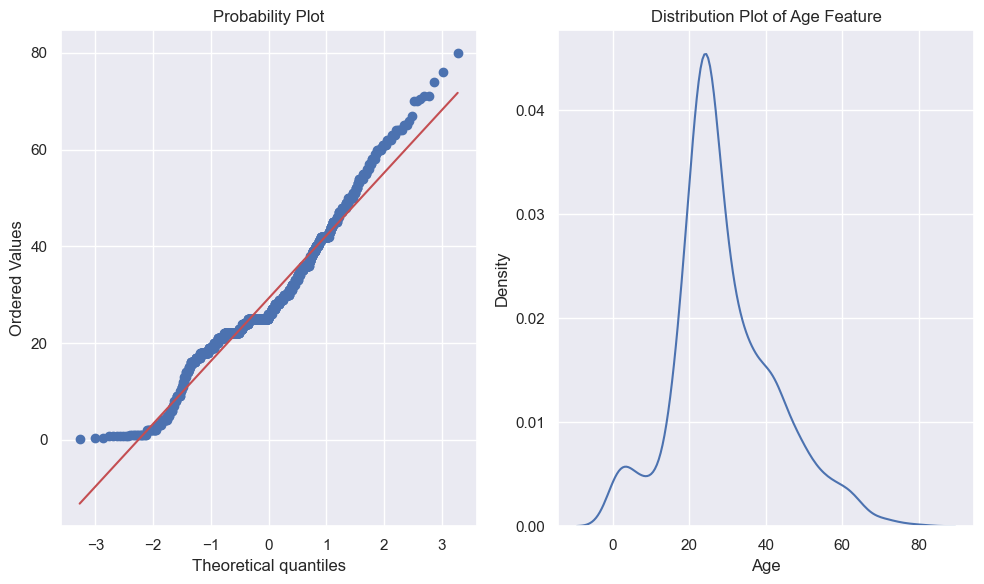

In [1050]:
import scipy.stats as stats

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,6))
stats.probplot(df_all.Age, dist='norm', plot=ax[0])
sns.distplot(df_all.Age, hist=False, ax=ax[1])
ax[1].set_title("Distribution Plot of Age Feature")
plt.tight_layout()
plt.show()

In [1053]:
df_all['Age'] = pd.qcut(df_all['Age'], 10)

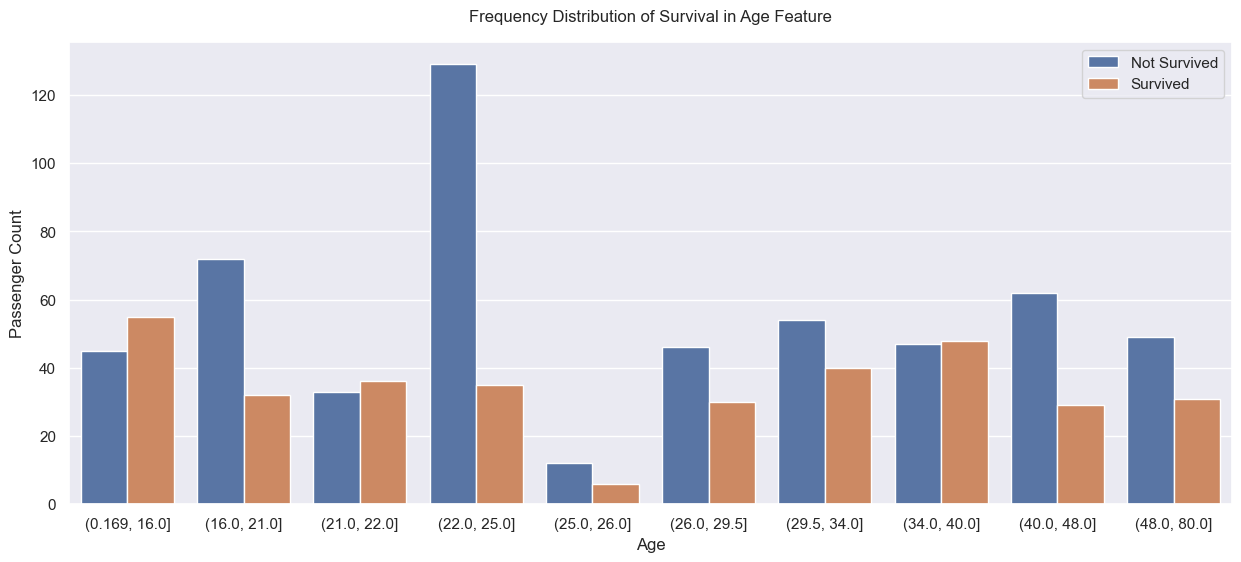

In [1054]:
fig = plt.figure(figsize=(15,6))
sns.countplot(x='Age', hue='Survived', data=df_all)
plt.legend(['Not Survived', 'Survived'])
plt.ylabel("Passenger Count")
plt.title("Frequency Distribution of Survival in Age Feature", pad=15)
plt.show()

## 2.2 Frequency Encoding

Creating a new feature `Family_Size` which will better represent features `Parch` and `SibSp` since:
- `SibSp` is the total number of passengers' siblings and spouse
- `Parch` is the total number of passengers' parents and children

`Family_Size` will be created by summing the feature columns.


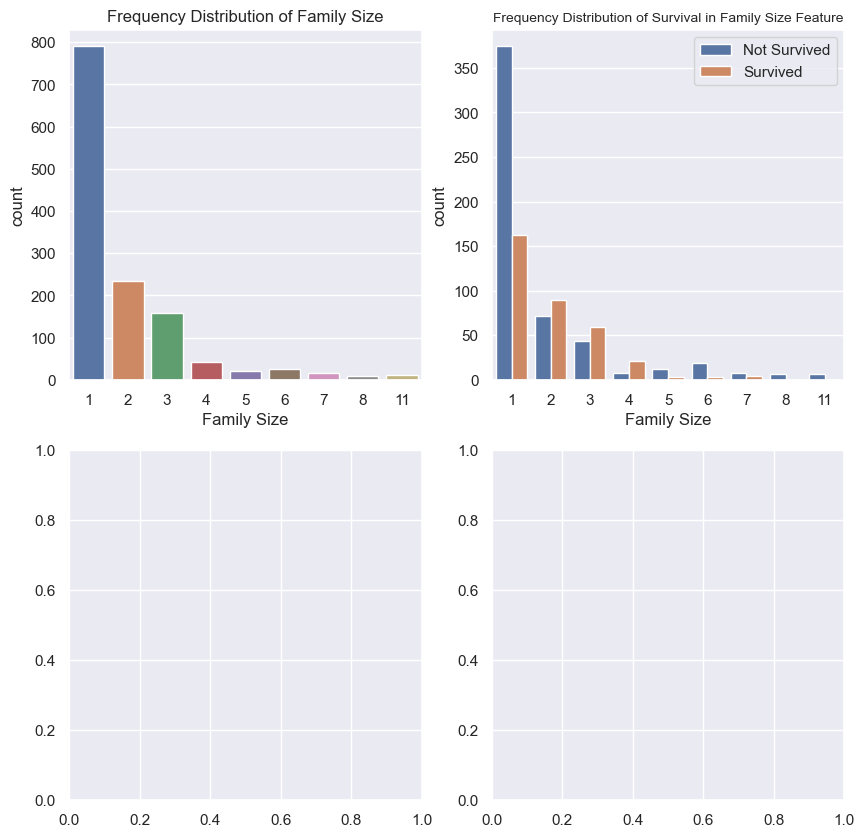

In [1071]:
df_all['Family_Size'] = df_all.Parch + df_all.SibSp + 1

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
sns.countplot(data=df_all, x='Family_Size', ax=ax[0][0])
sns.countplot(data=df_all, x='Family_Size', hue='Survived', ax=ax[0][1])

ax[0][0].set_xlabel('')
ax[0][0].set_title("Frequency Distribution of Family Size")

ax[0][1].legend(['Not Survived', 'Survived'])
ax[0][1].set_title('Frequency Distribution of Survival in Family Size Feature', size=10)
ax[0][1].set_xlabel('')

plt.show()